In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
from torch import nn
from torchvision import models
import copy
device = torch.device("cuda")
# %env CUBLAS_WORKSPACE_CONFIG=:4096:8
os.environ["TORCH_HOME"]="."
import sys
# torch.cuda.is_available()

from torchvision import models

########################################
# parameters to be set in training 

dropout = 0.2       # dropout rate in regression layer
lr = 0.001          # learning rate of optimizer
cv_epoches = 100    # cross validate epoches

########################################

############################################
# parameters to be set for encironment 
# NOT NEED to modify if you have the setting

data_root_path = "/hy-tmp/" # path to store train data
data_csv_filename = "DataNormilized.csv" # file to store params to be preprocessed
util_path = "/root/util"    # path to store the util package
batch_size = 128 # suitable for 4090
############################################

# add local dir to sys path
sys.path.insert(0, util_path) # the util package is supposed to be clone to this path
from util.torch_model.surf_model.modified_cnn_model import (
    ModifiedPretrainedNet,
    SurfNet256,
)

###################################################
# need to be modified for different pretrained net

model_name = "densenet121_input254_cv5"

pnet = ModifiedPretrainedNet(
    pretrained_net=models.densenet121,
    weights=models.DenseNet121_Weights.DEFAULT,
    name_first_conv="features.conv0",
    name_fc="classifier",
)
###################################################

training_model = SurfNet256(
    modified_net=pnet, 
    num_params=3, 
    num_output=2, 
    dropout=dropout
    )
# print(surf_model)
training_model.to(device)

from util.torch_model.surf_dateset import SurfDatasetFromMat

from torch import optim

optimizer = optim.Adam(training_model.parameters(), lr=lr)
loss_func = nn.MSELoss()

save_root_path = f"./checkpoint/{model_name}/"


In [2]:
checkpoint = torch.load(
    os.path.join(save_root_path, f"surf_{model_name}_best.ckpt")
)

/tmp/ipykernel_94829/2208142966.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


(0.0, 0.5)

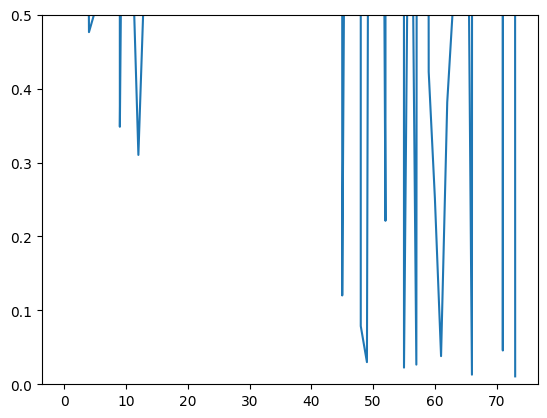

In [3]:
import matplotlib.pyplot as plt
loss = checkpoint["loss"]

plt.plot(loss["mean"])
plt.ylim([0,0.5])

In [4]:
training_model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [ ]:
def model_test(
    training_model, data_loader, loss_func, optim, device
):
    loss = 0
    training_model.eval()
    true_rst = {"area": np.zeros(0), "tcr": np.zeros(0)}
    pred_rst = {"area": np.zeros(0), "tcr": np.zeros(0)}
    for surf,para,targets in data_loader:
        optim.zero_grad()
        surf = surf.to(device)
        para = para.to(device)
        targets = targets.to(device)
        with torch.set_grad_enabled(False):
            outputs = training_model(surf, para)
            current_loss = loss_func(outputs, targets)
            true_rst["area"] = np.concatenate(
                    (true_rst["area"], targets[:, 0].detach().cpu().numpy()), axis=0
            )
            true_rst["tcr"] = np.concatenate(
                    (true_rst["tcr"], targets[:, 1].detach().cpu().numpy()), axis=0
                )
            pred_rst["area"] = np.concatenate(
                    (pred_rst["area"], outputs[:, 0].detach().cpu().numpy()), axis=0
                )
            pred_rst["tcr"] = np.concatenate(
                    (pred_rst["tcr"], outputs[:, 1].detach().cpu().numpy()), axis=0
                )
        loss += current_loss.item() * surf.size(0)
    loss_epoch = loss / len(data_loader)
    print(f"Test Loss: {loss_epoch:.4f} ")
    print("====================", end="\n")
    return true_rst, pred_rst

In [19]:
# test trained model
test_set = SurfDatasetFromMat(
        data_csv_filename=os.path.join(data_root_path, "test", data_csv_filename),
        surf_data_dir=os.path.join(data_root_path, "test", "Surf"),
        param_start_idx=3,
        param_end_idx=6,
        num_targets=2
    )
test_loader=DataLoader(
    dataset = test_set,
    batch_size=128,
    shuffle=False,
)


In [9]:
true_rst, pred_rst = model_test(
    training_model,
    loss_func=loss_func,
    optim=optimizer,
    dloader=test_loader,
    device=device,
)

967


ValueError: too many values to unpack (expected 3)

In [21]:
# 计算normalize之前的值
# 最大最小值normalize 的边界值
bounds = {"area": [-9.8, -4.8], "tcr": [2, 7.65]}
rst_sets = {"true": true_rst.copy(), "pred": pred_rst.copy()}
for label in ["area", "tcr"]:
    for set in ["true", "pred"]:
        rst_sets[set][label] = (
            rst_sets[set][label] * (bounds[label][1] - bounds[label][0])
            + bounds[label][0]
        )
        rst_sets[set][label] = np.exp(rst_sets[set][label])

0.9243778555084661


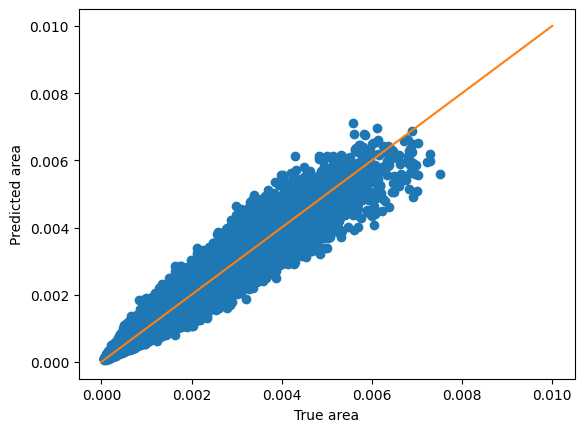

In [24]:
import matplotlib.pyplot as plt

plt.plot(rst_sets["true"]["area"], rst_sets["pred"]["area"], "o")
plt.plot([0, 0.01], [0, 0.01])
plt.xlabel("True area")
plt.ylabel("Predicted area")
from sklearn.metrics import r2_score

print(r2_score(rst_sets["true"]["area"], rst_sets["pred"]["area"]))

0.9799853481698877


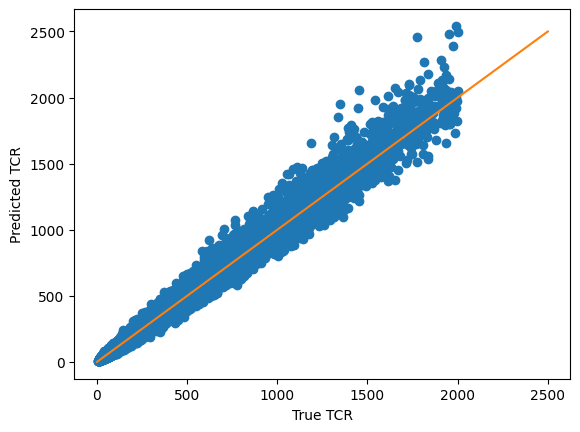

In [23]:
plt.plot(rst_sets["true"]["tcr"], rst_sets["pred"]["tcr"], "o")
plt.plot([0, 2500], [0, 2500])
plt.xlabel("True TCR")
plt.ylabel("Predicted TCR")
from sklearn.metrics import r2_score

print(r2_score(rst_sets["true"]["tcr"], rst_sets["pred"]["tcr"]))